# Imports/Downloads





In [1]:
!pip install rdkit
!pip install selfies
!pip install datamol
!pip install scikit-learn
!pip install torch-geometric
!pip install torch_scatter

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import random
import time
from pathlib import Path
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             roc_auc_score, precision_score, recall_score,
                             f1_score, roc_curve)

import matplotlib.pyplot as plt

from rdkit import Chem, RDLogger
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import Draw
import datamol as dm
import selfies as sf

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Bilinear, Linear, Parameter, Sequential

from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_add_pool
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset

from torch_scatter import scatter
from torch_geometric.data import Data

dm.disable_rdkit_log()

/opt/anaconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Sets seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Molecular Standardization + Defining Input

In [5]:
smiles_column = "smiles"

def preprocess(row):
    """

    Preprocesses smiles strings/mols for molecular standardization

    """
    # Iterates over rows to
    if row is None:
      return None

    mol = dm.to_mol(row[smiles_column], ordered=True)
    if mol is None:
      return None

    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(
        mol,
        disconnect_metals = False,
        normalize = True,
        reionize = True,
        uncharge = False,
        stereo = True,
    )

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)

    return row

# Defining Functions for Graph Feature Extraction

In [6]:
def one_hot_encoding(x, permitted_list):

    """

    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.

    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [7]:
def process_atoms(mol):
  """

  Makes sure there are no none atoms

  """
  atom_features_list = []

  for atom in mol.GetAtoms():
    atom_features = get_atom_features(atom)

    if atom is None:
      atom_features_list.append(atom_features)
      print(f"Skipping invalid atom with index: {atom.GetIdx()}")
      # append with zero vector with len of the feature vector
      atom_features_list.append(np.zeros(len(atom_features)))
    else:
       atom_features_list.append(atom_features)

  return atom_features_list

In [8]:
def get_atom_features(atom,
                      use_chirality=True,
                      hydrogens_implicit=True):
    """

    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.

    """
    try:
        if atom is None:
            # Handle the case where the atom is None
            return np.zeros(0)  # Returning a zero vector as a fallback

        # Proceed with feature extraction
        permitted_list_of_atoms = ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

        if hydrogens_implicit == False:
            permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

        atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
        n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
        formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
        hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
        is_in_a_ring_enc = [int(atom.IsInRing())]
        is_aromatic_enc = [int(atom.GetIsAromatic())]
        atomic_mass_scaled = [float((atom.GetMass() - 10.812) / 116.092)]
        vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5) / 0.6)]
        covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64) / 0.76)]

        atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

        if use_chirality:
            chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
            atom_feature_vector += chirality_type_enc

        if hydrogens_implicit:
            n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
            atom_feature_vector += n_hydrogens_enc

        return np.array(atom_feature_vector)

    except Exception as e:
        print(f"Error in processing atom {atom}: {e}")
        # Return a zero vector if any exception is encountered
        return np.zeros(0)

In [9]:
def get_bond_features(bond,
                      use_stereochemistry = True):
    """

    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.

    """
    if bond is None:
      return np.zeros(4)

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]

    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

# Create Graph Data

In [10]:
def smiles_to_data(smiles, label):
    """
    Inputs:

    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

    Outputs:

    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

    """

    data_list = []

    # convert SMILES to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
      print(f"Invalid SMILES string: {smiles}")
      return None

    #processing atoms to make sure there are no NoneType atoms
    atom_features_list = process_atoms(mol)

    # get feature dimensions
    n_nodes = len(atom_features_list)
    n_edges = 2 * mol.GetNumBonds()
    unrelated_smiles = "O=O"
    unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)

    n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))

    n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0, 1)))

    # construct node feature matrix X_features of shape (n_nodes, n_node_features)
    X_features = np.zeros((n_nodes, n_node_features))

    for atom in mol.GetAtoms():
      atom_features = get_atom_features(atom)
      X_features[atom.GetIdx(), :] = get_atom_features(atom)

    X_features = torch.tensor(X_features, dtype = torch.float)

    # construct edge index array of shape (2, n_edges)
    (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))

    torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
    torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([torch_rows, torch_cols], dim = 0)

    # construct edge feature array of shape (n_edges, n_edge_features)
    edge_attr = np.zeros((n_edges, n_edge_features))

    for (k, (i,j)) in enumerate(zip(rows, cols)):
        edge_attr[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

    edge_attr = torch.tensor(edge_attr, dtype = torch.float)

    # construct label tensor
    y_tensor = torch.tensor(np.array([label]), dtype = torch.long)

    # construct Pytorch Geometric data object and append to data list
    data_list.append(Data(x = X_features, edge_index = edge_index, edge_attr = edge_attr, y = y_tensor))

    return data_list

# Defining Model

In [11]:
# ---------------------------------------
# Attention layer
# ---------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce="max")
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce="sum")
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):
    def __init__(
        self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs
    ):
        kwargs.setdefault("aggr", "add")
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels, out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim, out_channels))
        else:
            self.weight_edge = self.register_parameter("weight_edge", None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):
        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = torch.max(x_j, edge_attr).view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out


class CustomGNN(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        edge_dim,
        num_layers,
        slices,
        dropout,
        f_att=False,
        r=4,
    ):
        super(CustomGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.f_att = f_att

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(
                hidden_channels,
                hidden_channels,
                slices=slices,
                dropout=dropout,
                edge_dim=hidden_channels,
            )
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        self.out = Linear(hidden_channels, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        self.out.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec = global_add_pool(x, batch).relu_()
        out = F.dropout(mol_vec, p=self.dropout, training=self.training)
        return self.out(out), out


class FocalLoss(nn.Module):
    """
    Multi-class Focal Loss
    """

    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, x, target):
        """
        input: [N, C], float32
        target: [N, ], int64
        """
        eps = 1e-10  # Avoid inf for log
        p = F.softmax(x, dim=1)
        logits = (1 - p) ** self.gamma * torch.log(p + eps)
        loss = F.nll_loss(logits, target)
        return loss

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    https://github.com/KaiyangZhou/pytorch-center-loss/blob/master/center_loss.py
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim   
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim)) # (2, 128)
        # self.centers = nn.Embedding(self.num_classes, self.feat_dim) # (2, 128)
        
    def forward(self, x, target): # (batch_size, last_feat_size) -> (32, 128)
        subtraction = x - 2*torch.matmul(F.one_hot(target).float(), self.centers)
        # norm2 = torch.linalg.norm(subtraction, dim=1, ord = 2)
        # norm2 = torch.clamp(norm2, min=1e-12, max=1e+12)
        loss = torch.mean(torch.pow(subtraction, 2))  / 2
        
        # batch_centers = self.centers(target)
        # dismat = torch.pow(x-batch_centers, 2)
        return loss


# Define Training, Testing, and Evaluation Loop

In [12]:
def train(model, optimizer, optimizer_cent, criterion_focal, criterion_cent, train_loader):
    model.train()
    device = torch.device("cpu")
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        optimizer_cent.zero_grad()
        out, feat_out = model(data)
        loss = criterion_focal(out, data.y.view(-1)) + 0.01* criterion_cent(feat_out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        optimizer_cent.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, test_loader):
    model.eval()
    device = torch.device("cpu")
    correct = 0
    y_pred, y_true = [], []

    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        pred = out.argmax(dim=1)
        y_pred.extend(pred.tolist())
        y_true.extend(data.y.view(-1).tolist())
        correct += (pred == data.y.view(-1)).sum().item()
    auc = roc_auc_score(y_true, y_pred)
    cf = confusion_matrix(y_true, y_pred)
    acc = correct / len(test_loader.dataset)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return acc, auc, cf, precision, recall, f1


def get_data_distribution(df):
    best_dist = []
    for task in list(df.columns.values)[1:]:
        # print(f"Processing {task}...")
        count = dict(df[task].value_counts(dropna=True))
        # print(count)
        zeros = count[0.0]
        ones = count[1.0]

        dist = ones / (ones + zeros)
        # print(f"Total: {ones+zeros}, ones: {ones}, ratio: {dist}")
        if dist > 0.5 and dist < 0.6:
            best_dist.append((task, dist))
    # print(f"Best task: {_label}, distribution: {best_dist}")
    return best_dist


def save_fig(cf, parent_dir, fig_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["0", "1"])
    output_path = os.path.join(parent_dir, f"{fig_name}.png")
    disp.plot()
    disp.figure_.savefig(output_path)
    plt.close("all")

# Actual training

In [13]:
# df = pd.read_csv("./toxcast_data.csv")
# df = df[["smiles", "CLD_CYP1A2_48hr"]].dropna()

In [ ]:
# Train
if __name__ == "__main__":
    df = pd.read_csv("./toxcast_data.csv")
    
    print(f"Number of rows in original dataset: {df.shape[0]}")
    print(f"Number of tasks: {df.shape[1] - 1}")
    print(f"Some Tasks: {list(df.columns.values)[1:5]}")

    best_dist = get_data_distribution(df)
    print(f"Number of tasks that aren't imbalanced: {len(best_dist)}")
    print(f"Some Tasks: {best_dist[:5]}")
    
    df = df.apply(preprocess, axis = 1)
    
    for i, task in enumerate(best_dist[:10]):
        # if "CLD_CYP1A2_48hr" not in task[0]:
        #    continue
        print(f"===> Processing {task[0]}, {i+1}/{len(best_dist)}...")
        
        # Determine in_channels before the loop
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        ### Load model
        model = CustomGNN(
            in_channels = n_node_features,
            hidden_channels = 128,
            out_channels = 2,
            edge_dim = 10,
            num_layers = 3,
            dropout = 0.3,
            slices =2 ,
            f_att = True,
            r = 4,
        )
        # criterion_focal = FocalLoss(gamma=2)
        criterion_focal = nn.CrossEntropyLoss(reduction="mean")
        criterion_cent = CenterLoss(num_classes=2, feat_dim=128)
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=5e-4)
        optimizer_cent = torch.optim.Adam(criterion_cent.parameters(), lr = 0.5, weight_decay=5e-4)
        

        ### Load data
        labels = []
        data_list = []
        for idx, row in df.iterrows():
            if not (pd.isna(row[task[0]])):
                data_obj_list = smiles_to_data(row["standard_smiles"], row[task[0]])
                if data_obj_list is not None:
                    if len(data_obj_list) > 1:
                        print("Consider error...")
                    for data_obj in data_obj_list:
                        labels.append(data_obj.y)
                        data_list.append(data_obj)

        print(f"Number of rows after preprocessing: {len(data_list)}")

        # Split into Training and Testing Sets
        batch_size = 32
        train_data, test_data = train_test_split(
            data_list, test_size=0.2, random_state=42, stratify=labels
        )
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        train_ones = [1 for sample in train_data if sample.y == 1]
        train_zeros = [0 for sample in train_data if sample.y == 0]
        test_ones = [1 for sample in test_data if sample.y == 1]
        test_zeros = [0 for sample in test_data if sample.y == 0]
        print(f"Number of training data: {len(train_data)}")
        print(f"    - Number of ones: {len(train_ones)}")
        print(f"    - Number of zeros: {len(train_zeros)}")
        print(f"Number of test data: {len(test_data)}")
        print(f"    - Number of ones: {len(test_ones)}")
        print(f"    - Number of zeros: {len(test_zeros)}")

        # Training loop
        num_epochs = 500
        best_auc, best_acc, best_precision, best_recall, best_f1 = [0] * 5
        best_auc_epoch, best_acc_epoch, best_f1_epoch = [0] * 3
        train_loss = []
        model_path = "best_models"
        fig_path = "figs"
        metrics_name = "metrics.txt"
        folder = "tasks-final-2"
        Path(os.path.join(folder, task[0], model_path)).mkdir(
            parents=True, exist_ok=True
        )
        Path(os.path.join(folder, task[0], fig_path)).mkdir(
            parents=True, exist_ok=True
        )
        output_file = open(os.path.join(folder, task[0], metrics_name), "w")

        start = time.time()
        for epoch in range(1, num_epochs + 1):
            loss = train(model, optimizer, optimizer_cent, criterion_focal, criterion_cent, train_loader)
            train_acc, train_auc, train_cf, train_precision, train_recall, train_f1 = test(model, train_loader)
            test_acc, test_auc, test_cf, test_precision, test_recall, test_f1 = test(model, test_loader)

            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}")
                print(f"    - Train Acc {train_acc:.4f}, Train AUC: {train_auc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
                print(f"    - Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
                if epoch > 100: 
                    if test_auc > best_auc:
                        best_auc_epoch = epoch
                        best_auc = test_auc
                        save_fig(
                            train_cf, os.path.join(folder, task[0], fig_path), "train"
                        )
                        save_fig(test_cf, os.path.join(folder, task[0], fig_path), "test")
                        torch.save(
                            model.state_dict(),
                            os.path.join(folder, task[0], model_path, "best_auc_model.pt"),
                        )
                    if test_acc > best_acc:
                        best_acc_epoch = epoch
                        best_acc = test_acc
                        torch.save(
                            model.state_dict(),
                            os.path.join(folder, task[0], model_path, "best_acc_model.pt"),
                        )
                    if test_f1 > best_f1:
                        best_f1_epoch = epoch
                        best_f1 = test_f1
                        best_precision = test_precision
                        best_recall = test_recall
                        torch.save(
                            model.state_dict(),
                            os.path.join(folder, task[0], model_path, "best_f1_model.pt"),
                        )
        end = time.time() - start
        output_file.write(f"Training time: {end} seconds\n")
        output_file.write(f"Epoch of best_acc on test set: {best_acc_epoch}\n")
        output_file.write(f"Best acc on test set: {best_acc}\n")
        output_file.write(f"Epoch of best_auc on test set: {best_auc_epoch}\n")
        output_file.write(f"Best AUC on test set: {best_auc}\n")
        output_file.write(f"Epoch of best_f1 on test set: {best_f1_epoch}\n")
        output_file.write(f"Best f1 on test set: {best_f1}\n")
        output_file.write(f"Best precision on test set: {best_precision}\n")
        output_file.write(f"Best recall on test set: {best_recall}\n")
        output_file.close()

Number of rows in original dataset: 8597
Number of tasks: 617
Some Tasks: ['ACEA_T47D_80hr_Negative', 'ACEA_T47D_80hr_Positive', 'APR_HepG2_CellCycleArrest_24h_dn', 'APR_HepG2_CellCycleArrest_24h_up']
Number of tasks that aren't imbalanced: 32
Some Tasks: [('CLD_CYP1A2_48hr', 0.5148514851485149), ('CLD_CYP2B6_24hr', 0.5761589403973509), ('CLD_CYP2B6_48hr', 0.5412541254125413), ('NCCT_HEK293T_CellTiterGLO', 0.5386666666666666), ('NCCT_QuantiLum_inhib_dn', 0.5517241379310345)]
===> Processing CLD_CYP1A2_48hr, 1/32...
Number of rows after preprocessing: 300
Number of training data: 240
    - Number of ones: 122
    - Number of zeros: 118
Number of test data: 60
    - Number of ones: 31
    - Number of zeros: 29
Epoch:  10, Loss: 0.6854
    - Train Acc 0.5083, Train AUC: 0.5000, Train Precision: 0.5083, Train Recall: 1.0000, Train F1: 0.6740
    - Test Acc: 0.5167, Test AUC: 0.5000, Test Precision: 0.5167, Test Recall: 1.0000, Test F1: 0.6813
Epoch:  20, Loss: 0.6788
    - Train Acc 0.6208

# Metrics

In [ ]:
import os

import numpy as np

if __name__ == "__main__":
    result_dir = "tasks-final-2/"
    tasks = os.listdir(result_dir)
    total_acc, total_auc, total_precision, total_recall, total_f1 = [0] * 5
    count = 0
    for task in tasks:
        if task == ".DS_Store":
            continue
        with open(result_dir + task + "/metrics.txt", "r") as f:
            data = f.readlines()
            acc = float(data[2].split()[-1])
            auc = float(data[4].split()[-1])
            f1 = float(data[6].split()[-1])
            print(f"AUC on test set of {task}: {auc:.3f}")
            count += 1
            total_acc += acc
            total_auc += auc
            total_f1 += f1

    print(f"Average ACC: {total_acc / count:.3f}")
    print(f"Average AUC: {total_auc / count:.3f}")
    print(f"Average F1: {total_f1 / count:.3f}")


In [16]:
from sklearn.manifold import TSNE
# target = torch.randint(0, 2, (1000,))
# feats = torch.matmul(F.one_hot(target).float(), criterion_cent.centers).detach().numpy()

x, y = [], []
device = torch.device("cpu")
for data in train_loader:
    data = data.to(device)
    out, feat = model(data)
    x.extend(feat.detach().numpy())
    y.extend(data.y.view(-1).tolist())
x = np.asarray(x)
y = np.asarray(y)
print(x.shape, y.shape)

X_embedded = TSNE(n_components=2, perplexity=30, max_iter=600).fit_transform(x)
y = y.reshape(-1, 1)

print(X_embedded.shape, y.shape)

(240, 128) (240,)
(240, 2) (240, 1)


In [281]:
print(X_embedded)

[[-4.97355700e+00 -5.54875493e-01]
 [-1.23794298e+01 -4.07731712e-01]
 [-6.66960955e+00  3.99799871e+00]
 [ 5.67201900e+00 -3.59622806e-01]
 [ 3.92360854e+00 -2.81687498e+00]
 [ 8.17890453e+00 -9.65917110e-02]
 [ 1.17743170e+00 -4.34530936e-02]
 [-3.62542152e+00  1.64842820e+00]
 [-4.27482510e+00  2.12926745e+00]
 [-7.48835468e+00  5.33024025e+00]
 [-1.10624475e+01 -1.13135993e+00]
 [-1.50564508e+01  8.73731822e-02]
 [ 2.08577843e+01 -4.92899036e+00]
 [ 1.00784674e+01 -4.91804153e-01]
 [ 8.88181973e+00 -3.70121121e+00]
 [-7.81862736e+00  1.33545220e+00]
 [-1.36816311e+01  6.03739023e+00]
 [ 2.39323959e+01 -5.51387501e+00]
 [ 1.58212852e+01 -3.36838722e-01]
 [ 2.06893578e+01 -5.71357679e+00]
 [ 1.37361155e+01 -1.18471587e+00]
 [-1.56372986e+01  8.39944839e+00]
 [ 1.80401001e+01 -3.43138194e+00]
 [ 2.47827129e+01 -5.85504818e+00]
 [-1.51192141e+01 -1.10661566e+00]
 [-1.27241325e+01  1.96647024e+00]
 [ 2.14089737e+01 -4.13539982e+00]
 [-1.54610357e+01  4.40424919e+00]
 [ 2.04703140e+01 -3

In [282]:
print(X_embedded[y.flatten() == 0].shape)

(118, 2)


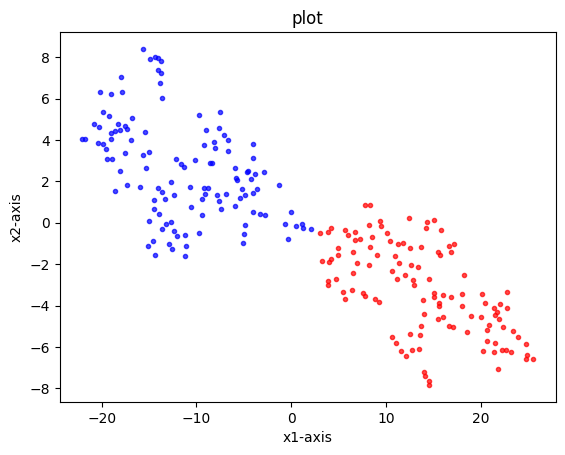

In [283]:
# Define colors for each class
# colors = ['red' if label == 0 else 'blue' for label in y]
colors = ['red', 'blue']
plt.ion()
plt.clf()
for i in range(2):
    plt.plot(X_embedded[y.flatten() == i, 0], X_embedded[y.flatten() == i, 1], '.', c=colors[i], alpha=0.7)
plt.xlabel("x1-axis")
plt.ylabel("x2-axis")
plt.title("plot")
plt.show()